## Imports

In [1]:
import pandas as pd
import numpy as np
import hashlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


## Dataset (Q1) and Regression


 Analysis for: No Regularization 


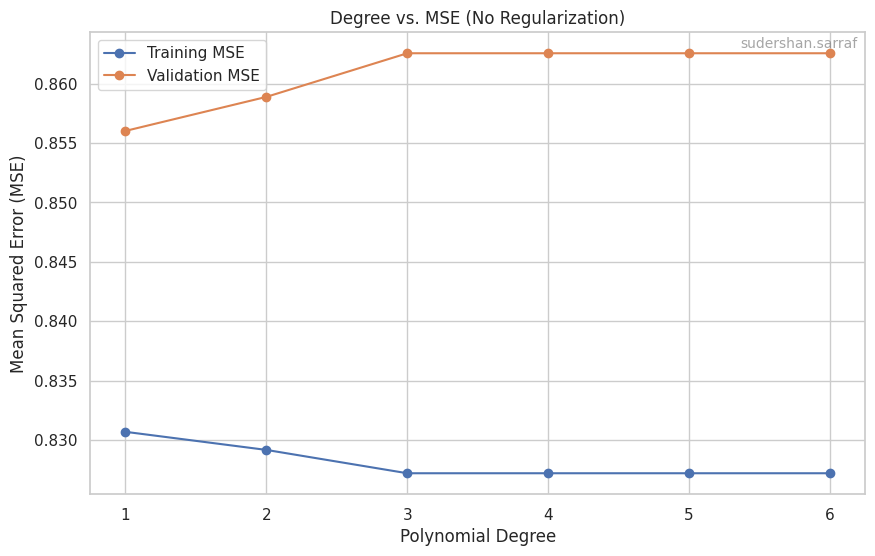


 Analysis for: L1 


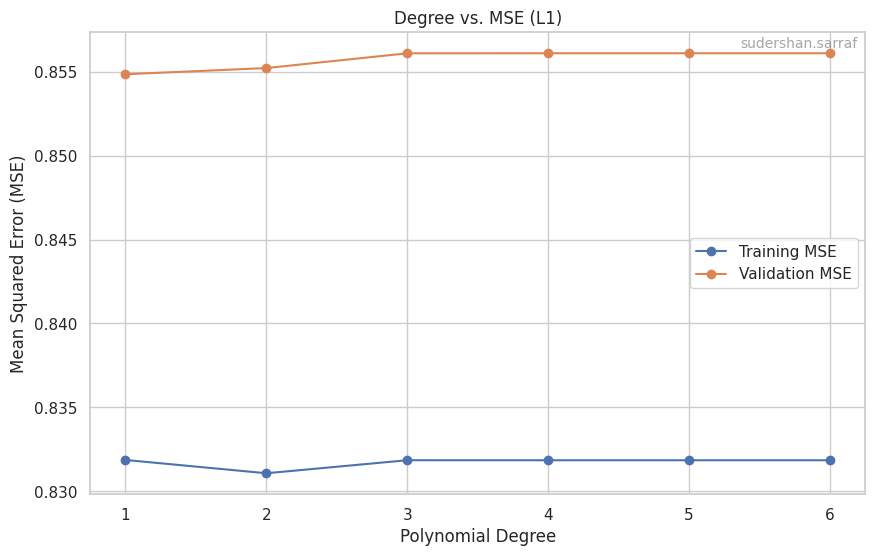

Best degree for L1 was 1. Plotting strength vs. MSE for this degree.


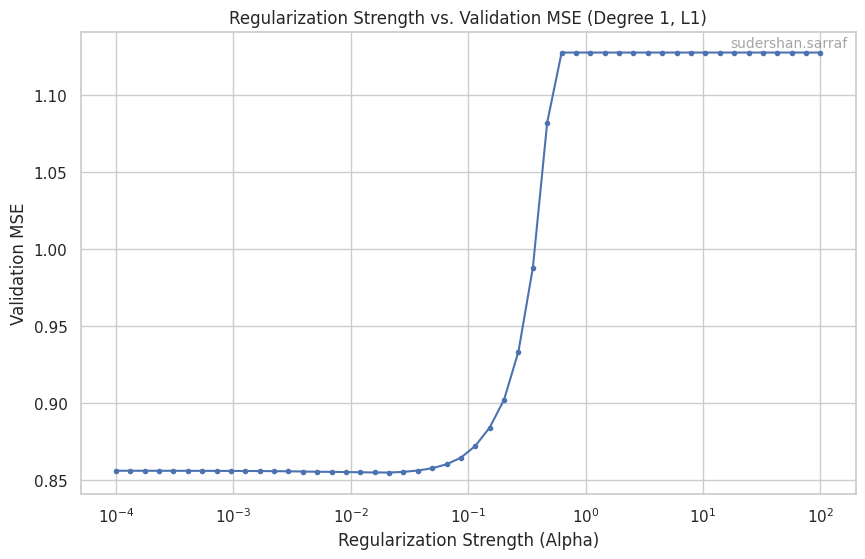


 Analysis for: L2 


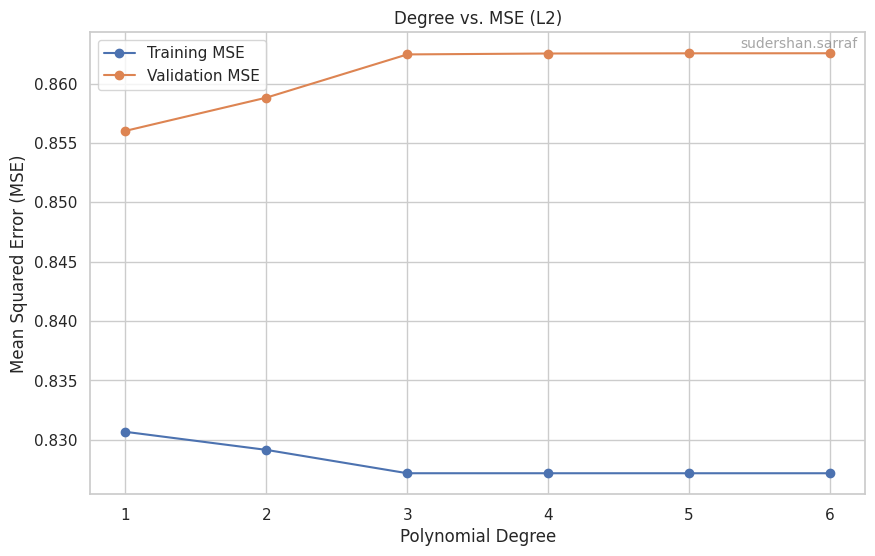

Best degree for L2 was 1. Plotting strength vs. MSE for this degree.


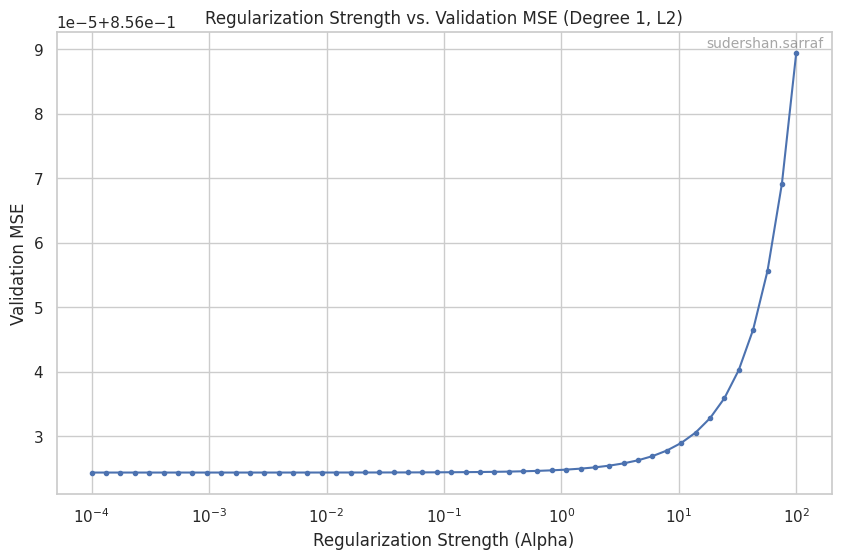


 Final Observations 
The best overall performance on the test set was achieved with:
  Regularizer: None
  Degree: 1
  Best Test MSE: 0.7973

The trend observed is that as the polynomial degree increases, the training MSE consistently decreases because the model fits the training data more closely. However, the validation MSE typically decreases at first and then starts to increase, indicating overfitting.
Regularization helps combat this overfitting, often leading to better performance on the test set, especially at higher degrees.

For the best L1 (Lasso) setup:
  Number of non-zero features: 3
  These features are considered the most important as L1 drives other coefficients to exactly zero.

For the best L2 (Ridge) setup:
  L2 regularization shrinks all coefficients towards zero but rarely makes them exactly zero. All features are typically retained, but their influence is reduced.


In [4]:
# This includes the dataset generation from A1 and other initial settings.
username = "sudershan.sarraf" 
seed = int(hashlib.sha256(username.encode()).hexdigest(), 16) % (2**32)
sns.set_theme(style="whitegrid")

class StudentDataset:
    """A class to generate and manage the student dataset."""
    def __init__(self, num_students: int, seed: int):
        self.num_students = num_students
        self.rng = np.random.default_rng(seed)
        self.username = username
        self._full_df = self._assemble_dataframe()

    def get_full_dataframe(self) -> pd.DataFrame:
        return self._full_df.copy()

    def _generate_gender(self) -> list[str]:
        return self.rng.choice(["Male", "Female", "Other"], self.num_students, p=[0.65, 0.33, 0.02])
    
    def _generate_major(self) -> list[str]:
        return self.rng.choice(["B.Tech", "MS", "PhD"], self.num_students, p=[0.70, 0.20, 0.10])

    def _generate_program(self, majors: list[str]) -> list[str]:
        p_dist = {"B.Tech": {"choices": ["CSE", "ECE", "CHD", "CND"], "probs": [0.4, 0.4, 0.1, 0.1]}, "MS": {"choices": ["CSE", "ECE", "CHD", "CND"], "probs": [0.3, 0.3, 0.2, 0.2]}, "PhD": {"choices": ["CSE", "ECE", "CHD", "CND"], "probs": [0.25, 0.25, 0.25, 0.25]}}
        return [self.rng.choice(p_dist[major]["choices"], p=p_dist[major]["probs"]) for major in majors]

    def _generate_gpa(self, majors: list[str]) -> list[float]:
        gpa_dist = {"B.Tech": {"mean": 7.0, "std": 1.0},"MS": {"mean": 8.0, "std": 0.7},"PhD": {"mean": 8.3, "std": 0.5}}
        gpas = [self.rng.normal(loc=gpa_dist[major]["mean"], scale=gpa_dist[major]["std"]) for major in majors]
        return np.clip(gpas, 4.0, 10.0).tolist()

    def _assemble_dataframe(self) -> pd.DataFrame:
        majors = self._generate_major()
        return pd.DataFrame({'gender': self._generate_gender(), 'major': majors, 'program': self._generate_program(majors), 'gpa': self._generate_gpa(majors)})

class RegressionAnalysis:
    """Handles the polynomial regression analysis for predicting GPA."""
    def __init__(self, student_df: pd.DataFrame, username: str):
        self.full_df = student_df
        self.username = username
        self.X_train, self.X_val, self.X_test = None, None, None
        self.y_train, self.y_val, self.y_test = None, None, None
        self._prepare_data()

    def _add_username_to_plot(self, ax):
        ax.text(0.99, 0.99, self.username,
                ha='right', va='top', transform=ax.transAxes,
                fontsize=10, color='gray', alpha=0.7)

    def _prepare_data(self):
        """Prepares data by encoding features and splitting into sets."""
        features = ['gender', 'major', 'program']
        target = 'gpa'
        X = self.full_df[features]
        y = self.full_df[target]

        # One-hot encode categorical features before splitting.
        categorical_features = ['gender', 'major', 'program']
        preprocessor = ColumnTransformer(
            transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)],
            remainder='passthrough'
        )
        X_processed = preprocessor.fit_transform(X)
        self.feature_names = preprocessor.get_feature_names_out()

        # Split data into 60% train, 20% validation, and 20% test.
        self.X_train_val, self.X_test, self.y_train_val, self.y_test = train_test_split(X_processed, y, test_size=0.2, random_state=seed)
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.X_train_val, self.y_train_val, test_size=0.25, random_state=seed) # 0.25 * 0.8 = 0.2

    def run_poly_regression(self, X_train, y_train, X_val, y_val, X_test, y_test, degree=1, regularizer=None, reg_strength=0.0):
        """
        Fits a polynomial regression model with optional regularization.
        """
        # Select the appropriate regression model based on the regularizer.
        if regularizer == 'l1':
            model = Lasso(alpha=reg_strength, max_iter=10000, tol=0.01)
        elif regularizer == 'l2':
            model = Ridge(alpha=reg_strength)
        else:
            model = LinearRegression()
        
        # Create a pipeline to manage transformations and the model.
        pipeline = Pipeline([
            ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
            ('scaler', StandardScaler()),
            ('reg', model)
        ])
        
        pipeline.fit(X_train, y_train)
        
        # Calculate MSE on all data splits.
        results = {
            'train_mse': mean_squared_error(y_train, pipeline.predict(X_train)),
            'val_mse': mean_squared_error(y_val, pipeline.predict(X_val)),
            'test_mse': mean_squared_error(y_test, pipeline.predict(X_test)),
            'coefficients': pipeline.named_steps['reg'].coef_,
            'degree': degree,
            'alpha': reg_strength
        }
        return results

    def plot_degree_vs_mse(self, degrees, train_mses, val_mses, title):
        """Plots the polynomial degree against MSE for train and validation sets."""
        plt.figure(figsize=(10, 6))
        ax = plt.gca()
        ax.plot(degrees, train_mses, marker='o', label='Training MSE')
        ax.plot(degrees, val_mses, marker='o', label='Validation MSE')
        ax.set_title(title)
        ax.set_xlabel('Polynomial Degree')
        ax.set_ylabel('Mean Squared Error (MSE)')
        ax.legend(); ax.grid(True)
        self._add_username_to_plot(ax)
        plt.show()
    
    def find_best_reg_strength(self, degree, regularizer, plot=False):
        """Finds the best regularization strength for a given degree and plots the results."""
        alphas = np.logspace(-4, 2, 50)
        best_alpha = None
        min_val_mse = float('inf')
        val_mses_for_plot = []

        for alpha in alphas:
            results = self.run_poly_regression(self.X_train, self.y_train, self.X_val, self.y_val, self.X_test, self.y_test, 
                                               degree=degree, regularizer=regularizer, reg_strength=alpha)
            val_mses_for_plot.append(results['val_mse'])
            if results['val_mse'] < min_val_mse:
                min_val_mse = results['val_mse']
                best_alpha = alpha
        
        # Plot only for the best degree as requested by the assignment.
        if plot:
            plt.figure(figsize=(10, 6))
            ax = plt.gca()
            ax.plot(alphas, val_mses_for_plot, marker='.')
            ax.set_xscale('log')
            ax.set_title(f'Regularization Strength vs. Validation MSE (Degree {degree}, {regularizer.upper()})')
            ax.set_xlabel('Regularization Strength (Alpha)')
            ax.set_ylabel('Validation MSE')
            ax.grid(True)
            self._add_username_to_plot(ax)
            plt.show()

        return best_alpha, min_val_mse

# Execution

# Generate the student dataset.
student_data = StudentDataset(num_students=10000, seed=seed)
df_full = student_data.get_full_dataframe()

# Initialize the analysis class.
analysis = RegressionAnalysis(df_full, username)

degrees = range(1, 7)
setups = [None, 'l1', 'l2']
best_results = {}

for setup in setups:
    train_mses = []
    val_mses = []
    best_degree_for_setup = -1
    min_val_mse_for_setup = float('inf')
    
    setup_name = str(setup).upper() if setup else 'No Regularization'
    print(f"\n Analysis for: {setup_name} ")
    
    for degree in degrees:
        if setup:
            best_alpha, val_mse = analysis.find_best_reg_strength(degree, setup)
            results = analysis.run_poly_regression(analysis.X_train, analysis.y_train, analysis.X_val, analysis.y_val, analysis.X_test, analysis.y_test,
                                                   degree=degree, regularizer=setup, reg_strength=best_alpha)
        else:
            results = analysis.run_poly_regression(analysis.X_train, analysis.y_train, analysis.X_val, analysis.y_val, analysis.X_test, analysis.y_test, degree=degree)
        
        train_mses.append(results['train_mse'])
        val_mses.append(results['val_mse'])

        # Find the best degree for the current setup based on validation MSE.
        if results['val_mse'] < min_val_mse_for_setup:
            min_val_mse_for_setup = results['val_mse']
            best_degree_for_setup = degree
            best_results[setup] = results # Store results for the best degree

    # Plot degree vs. MSE for the current setup.
    analysis.plot_degree_vs_mse(degrees, train_mses, val_mses, f'Degree vs. MSE ({setup_name})')
    
    # For regularized models, plot alpha vs. MSE for the best degree found.
    if setup:
        print(f"Best degree for {setup_name} was {best_degree_for_setup}. Plotting strength vs. MSE for this degree.")
        analysis.find_best_reg_strength(best_degree_for_setup, setup, plot=True)


# Determine the best overall model from the stored best results.
best_overall_test_mse = float('inf')
best_overall_setup_key = None
for key, result in best_results.items():
    if result['test_mse'] < best_overall_test_mse:
        best_overall_test_mse = result['test_mse']
        best_overall_setup_key = key

# Get the details of the best setup.
best_setup_details = best_results[best_overall_setup_key]
best_regularizer = best_overall_setup_key
best_degree = best_setup_details['degree']
best_alpha = best_setup_details['alpha']

print("\n Final Observations ")
print(f"The best overall performance on the test set was achieved with:")
print(f"  Regularizer: {str(best_regularizer).upper() if best_regularizer else 'None'}")
print(f"  Degree: {best_degree}")
if best_regularizer:
    print(f"  Alpha: {best_alpha:.4f}")
print(f"  Best Test MSE: {best_overall_test_mse:.4f}\n")

print("The trend observed is that as the polynomial degree increases, the training MSE consistently decreases because the model fits the training data more closely. However, the validation MSE typically decreases at first and then starts to increase, indicating overfitting.")
print("Regularization helps combat this overfitting, often leading to better performance on the test set, especially at higher degrees.\n")

# Analyze coefficients for the best L1 and L2 models.
if 'l1' in best_results:
    best_l1_degree = best_results['l1']['degree']
    poly_l1 = PolynomialFeatures(degree=best_l1_degree, include_bias=False)
    poly_l1.fit(analysis.X_train)
    feature_names_poly_l1 = poly_l1.get_feature_names_out(analysis.feature_names)
    best_l1_coeffs = best_results['l1']['coefficients']
    
    print("For the best L1 (Lasso) setup:")
    non_zero_coeffs_l1 = {name: coef for name, coef in zip(feature_names_poly_l1, best_l1_coeffs) if abs(coef) > 1e-6}
    print(f"  Number of non-zero features: {len(non_zero_coeffs_l1)}")
    print("  These features are considered the most important as L1 drives other coefficients to exactly zero.")

if 'l2' in best_results:
    print("\nFor the best L2 (Ridge) setup:")
    print("  L2 regularization shrinks all coefficients towards zero but rarely makes them exactly zero. All features are typically retained, but their influence is reduced.")

